In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

from validate import validation_metrics, calibration_metrics
import pandas as pd
from sklearn.metrics import roc_curve

plt.style.use('utils\plotstyle.mplstyle')

# Load data

In [2]:
device = 'cuda'

In [39]:
folder = 'UNIFESP+iCOPE'
model = 'NCNN_test' # change model here

path_experiments = f'experiments\\{folder}\\{model}'

In [40]:
if "NCNN" in model:
    theta_1 = 0.5420
    best_fold = '9'
elif "VGGNB" in model:
    theta_1 = 0.4944
    best_fold = '7'
else:
    theta_1 = 0.35
    best_fold = '8'


In [41]:
with open(os.path.join(path_experiments,f'results.pkl'), 'rb') as f:
    results = pickle.load(f)

# Youden Index

tpr == sensitivity
fpr == 1 - specificity

In [42]:
threshs_probs = []

for i, fold in enumerate(results.keys()):

    preds = results[fold]['preds']
    labels = results[fold]['labels']
    probs = results[fold]['probs']

    fpr_probs, tpr_probs, thresholds_probs = roc_curve(labels, probs)
    idx_probs = np.argmax(tpr_probs - fpr_probs)
    threshs_probs.append(thresholds_probs[idx_probs])

threshs_probs = np.asarray(threshs_probs)


In [43]:
print(f"Avg thresh for probs: {threshs_probs.mean():.4f}+-{threshs_probs.std():.4f}")

Avg thresh for probs: 0.5420+-0.1350


In [44]:
threshs_probs

array([0.7029013 , 0.71919686, 0.49893546, 0.40895367, 0.46171308,
       0.37373117, 0.37317178, 0.62200224, 0.73075604, 0.5290864 ],
      dtype=float32)

In [45]:
accuracy_tresh = np.zeros(len(results.keys()))
f1_tresh = np.zeros(len(results.keys()))
precision_tresh = np.zeros(len(results.keys()))
sensitivity_tresh = np.zeros(len(results.keys()))
specificity_tresh = np.zeros(len(results.keys()))
auc_tresh = np.zeros(len(results.keys()))

for i, fold in enumerate(results.keys()):

    preds = results[fold]['probs'] >= threshs_probs[i]

    metrics = validation_metrics(preds, results[fold]['probs'], results[fold]['labels'])
    accuracy_tresh[i] = metrics['Accuracy']
    f1_tresh[i] = metrics['F1 Score']
    precision_tresh[i] = metrics['Precision']
    sensitivity_tresh[i] = metrics['Sensitivity']
    specificity_tresh[i] = metrics['Specificity']
    auc_tresh[i] = metrics['AUC']

In [46]:
s = ''
for x in [accuracy_tresh,f1_tresh,precision_tresh,sensitivity_tresh,specificity_tresh,auc_tresh]:
    for i in x[:-1]:
        s = s + str(i.round(4)).replace('.',',') + ';'
    s = s + str(x[-1].round(4)).replace('.',',') + '\n'
print(s)

0,8525;0,7755;0,8793;0,6923;0,8431;0,8983;0,7619;0,8491;0,8889;0,9231
0,8571;0,7317;0,8679;0,7037;0,7778;0,8929;0,717;0,8571;0,8947;0,8966
0,871;0,9375;0,8846;0,5429;0,8235;0,9259;0,6786;0,8276;0,8947;1,0
0,8438;0,6;0,8519;1,0;0,7368;0,8621;0,76;0,8889;0,8947;0,8125
0,8621;0,9583;0,9032;0,5152;0,9062;0,9333;0,7632;0,8077;0,8824;1,0
0,9095;0,8383;0,9271;0,8006;0,8931;0,923;0,8158;0,9003;0,9536;0,9429



## By dataset

In [47]:
folds = []
preds = []
probs = []
labels = []
imgs = []

# Cria arrays com os resultados
for i, fold in enumerate(results.keys()):
    folds.extend([fold]*len(results[fold]['labels']))
    preds.extend(results[fold]['preds'])
    probs.extend(results[fold]['probs'])
    labels.extend(results[fold]['labels'])
    imgs.extend([path.split("_")[1] for path in results[fold]['img_names']])


dataframe = pd.DataFrame({'folds': folds, 'dataset': imgs, 'labels': labels, 'preds': preds, 'probs': probs})

In [48]:
# Validation metrics
accuracy_unifesp = np.zeros(len(results.keys()))
f1_unifesp = np.zeros(len(results.keys()))
precision_unifesp = np.zeros(len(results.keys()))
sensitivity_unifesp = np.zeros(len(results.keys()))
specificity_unifesp = np.zeros(len(results.keys()))
auc_unifesp = np.zeros(len(results.keys()))

# Validation metrics
accuracy_icope = np.zeros(len(results.keys()))
f1_icope = np.zeros(len(results.keys()))
precision_icope = np.zeros(len(results.keys()))
sensitivity_icope = np.zeros(len(results.keys()))
specificity_icope = np.zeros(len(results.keys()))
auc_icope = np.zeros(len(results.keys()))


for i in range(10):
    fold_dataframe = dataframe[dataframe['folds'] == str(i)]
    
    dataframe_unifesp = fold_dataframe[fold_dataframe['dataset']=="UNIFESP"]
    dataframe_icope = fold_dataframe[fold_dataframe['dataset']=="iCOPE"]

    preds_unifesp = dataframe_unifesp['probs'] >= threshs_probs[i]

    metrics_unifesp = validation_metrics(preds_unifesp, dataframe_unifesp['probs'], dataframe_unifesp['labels'])

    accuracy_unifesp[i] = metrics_unifesp['Accuracy']
    f1_unifesp[i] = metrics_unifesp['F1 Score']
    precision_unifesp[i] = metrics_unifesp['Precision']
    sensitivity_unifesp[i] = metrics_unifesp['Sensitivity']
    specificity_unifesp[i] = metrics_unifesp['Specificity']
    auc_unifesp[i] = metrics_unifesp['AUC']

    preds_icope = dataframe_icope['probs'] >= threshs_probs[i]

    metrics_icope = validation_metrics(preds_icope, dataframe_icope['probs'], dataframe_icope['labels'])

    accuracy_icope[i] = metrics_icope['Accuracy']
    f1_icope[i] = metrics_icope['F1 Score']
    precision_icope[i] = metrics_icope['Precision']
    sensitivity_icope[i] = metrics_icope['Sensitivity']
    specificity_icope[i] = metrics_icope['Specificity']
    auc_icope[i] = metrics_icope['AUC']

In [49]:
s = ''
for x in [accuracy_unifesp,f1_unifesp,precision_unifesp,sensitivity_unifesp,specificity_unifesp,auc_unifesp]:
    for i in x[:-1]:
        s = s + str(i.round(4)).replace('.',',') + ';'
    s = s + str(x[-1].round(4)).replace('.',',') + '\n'
print(s)

0,875;0,7222;0,8511;0,6667;0,8824;0,8611;0,7667;0,8056;0,9167;0,875
0,875;0,6429;0,8293;0,6364;0,8333;0,8485;0,7083;0,8293;0,9412;0,8
0,9545;0,9;0,85;0,4667;0,9091;0,875;0,68;0,7727;1,0;1,0
0,8077;0,5;0,8095;1,0;0,7692;0,8235;0,7391;0,8947;0,8889;0,6667
0,9545;0,9444;0,8846;0,5294;0,9524;0,8947;0,7838;0,7059;1,0;1,0
0,9353;0,8117;0,8956;0,7059;0,9011;0,8576;0,8073;0,8328;0,9259;0,8815



In [50]:
s = ''
for x in [accuracy_icope,f1_icope,precision_icope,sensitivity_icope,specificity_icope,auc_icope]:
    for i in x[:-1]:
        s = s + str(i.round(4)).replace('.',',') + ';'
    s = s + str(x[-1].round(4)).replace('.',',') + '\n'
print(s)

0,7692;0,9231;1,0;0,7143;0,7647;0,9565;0,6667;0,9412;0,875;1,0
0,8;0,9231;1,0;0,75;0,6667;0,9565;0,8;0,9333;0,8571;1,0
0,6667;1,0;1,0;0,6;0,6667;1,0;0,6667;1,0;0,8182;1,0
1,0;0,8571;1,0;1,0;0,6667;0,9167;1,0;0,875;0,9;1,0
0,5714;1,0;1,0;0,5;0,8182;1,0;0,0;1,0;0,8571;1,0
0,9524;0,9286;1,0;0,849;0,9242;0,9924;1,0;1,0;0,95;1,0



# ROC CURVE

from sklearn.metrics import roc_auc_score, roc_curve

alpha= 0.2

folder = 'UNIFESP+iCOPE'
model = 'NCNN_test' # change model here

path_experiments = f'experiments\\{folder}\\{model}'

with open(os.path.join(path_experiments,f'results.pkl'), 'rb') as f:
    results = pickle.load(f)
    
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold in results.keys():

    fpr, tpr, _ = roc_curve(results[fold]['labels'], results[fold]['probs'])

    auc = roc_auc_score(results[fold]['labels'], results[fold]['probs'])
    #plt.plot(fpr, tpr, lw=1,color='#d4d4d2')  # Plot ROC curve

    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(auc)

   
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)


plt.plot(mean_fpr, mean_tpr, label=f'AUC N_CNN = {mean_auc:.4f} ± {std_auc:.2f}')
plt.fill_between(mean_fpr, np.clip(mean_tpr-std_tpr,0,1),np.clip(mean_tpr+std_tpr,0,1), alpha=alpha, edgecolor='None')

folder = 'UNIFESP+iCOPE'
model = 'VGGNB_test' # change model here

path_experiments = f'experiments\\{folder}\\{model}'

with open(os.path.join(path_experiments,f'results.pkl'), 'rb') as f:
    results = pickle.load(f)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold in results.keys():

    fpr, tpr, _ = roc_curve(results[fold]['labels'], results[fold]['probs'])

    auc = roc_auc_score(results[fold]['labels'], results[fold]['probs'])
    #plt.plot(fpr, tpr, lw=1,color='#d4d4d2')  # Plot ROC curve

    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(auc)

   
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)


plt.plot(mean_fpr, mean_tpr, label=f'AUC VGG = {mean_auc:.4f} ± {std_auc:.2f}')
plt.fill_between(mean_fpr, np.clip(mean_tpr-std_tpr,0,1),np.clip(mean_tpr+std_tpr,0,1), alpha=alpha, edgecolor='None')

#plt.title(f'ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig(f"roc_curve_{model}.png", dpi=150, bbox_inches='tight')


In [51]:
from scipy.signal import butter, lfilter, freqz, filtfilt

In [52]:
path_icopevid = 'Datasets\\Originais\\iCOPE\\iCOPEvid'
path_icopevid_frames = 'Datasets\\Originais\\iCOPE\\iCOPEvid\\all_frames'

with open(os.path.join(path_icopevid_frames,f'results_{model}.pkl'), 'rb') as f:
    results_video = pickle.load(f)


In [53]:
from validate import validation_metrics
from scipy import stats
import matplotlib
import glob
from scipy.stats import entropy
from scipy import integrate
from scipy.signal import butter, lfilter, freqz, filtfilt

def butter_lowpass_filter(data, cutoff=2, fs=30, order=2):
    normal_cutoff = cutoff / (0.5 * fs)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def get_hist(signal):
    return np.histogram(signal, bins=np.linspace(0.0, 1.0, 11))

def get_probs(signal):
    hist, _ = get_hist(signal)
    return hist / len(signal)

def get_entropy(signal):
    pk = get_probs(signal)
    return entropy(pk, base=2)

def get_entropy_curve(signal):
    hist, bin_edges = get_hist(signal)
    pk = hist / len(signal)
    entropies = []
    for x in signal:
        idx = np.digitize(x, bin_edges, right=True)
        pkx = pk[idx-1]
        entropies.append(-((pkx * np.log(pkx)) / np.log(2)))
    return entropies

def get_auc(signal):
    return integrate.trapezoid(signal) / len(signal)

def get_auc_curve(signal):
    window_size = 10
    step = 1
    auc_curve = []
    for x in range(0, len(signal)-window_size, step):
        window = signal[x:x+window_size]
        auc_curve.append(get_auc(window))
    return auc_curve

def interp_curve(signal):
    time = np.linspace(0,len(signal),len(signal))
    # Find indices of missing values
    missing_indices = np.isnan(signal)
    # Find indices of non-missing values
    valid_indices = ~missing_indices
    # Perform linear interpolation
    interpolated_values = np.interp(time[missing_indices], time[valid_indices], signal[valid_indices])
    # Replace missing values with interpolated values
    signal[missing_indices] = interpolated_values

    return signal

def fill_nan(signal):
    # Find indices of missing values
    missing_indices = np.isnan(signal)
    # Find indices of non-missing values
    valid_indices = ~missing_indices
    # Perform linear interpolation
    mean = np.mean(signal[valid_indices])
    # Replace missing values with interpolated values
    signal[missing_indices] = mean

    return signal


def peak_to_peak(signal):
    return (np.abs(np.max(signal)) - np.abs(np.min(signal)))

def derivative(signal, power=False):
    if power:
        return np.power(np.diff(signal),2)
    else:
        return np.diff(signal)
    
def RMS(signal):
    return np.sqrt(np.mean(np.square(signal)))

def thresh_crossing(signal, thresh=0.5):
    return len(np.where(np.diff(np.sign(signal-thresh)))[0]) 

In [54]:
all_probs = []
all_entropy = []
all_crossings = []
all_preds = []
all_curves = []

labels = []

for video in results_video.keys():

    #plt.figure(figsize=(20,5))
    interpoleted_curve = interp_curve(results_video[video][best_fold])
    filtered_curve = moving_average(interpoleted_curve, 30)
    #plt.plot(filtered_curve)
    #plt.ylim([0,1.01])
    #plt.show()

    all_curves.append(filtered_curve)
    all_probs.append(filtered_curve.mean())
    all_preds.append(filtered_curve.mean() >= theta_1)
    all_entropy.append(get_entropy(filtered_curve))
    all_crossings.append(thresh_crossing(filtered_curve, theta_1))
    
    if "Pain" in video:
        labels.append(1)
    else:
        labels.append(0)

all_probs = np.array(all_probs)
all_entropy = np.array(all_entropy)
all_crossings = np.array(all_crossings)
all_preds = np.array(all_preds)

In [55]:
metrics = validation_metrics(all_preds, all_probs, np.array(labels))
accuracy = metrics['Accuracy']
f1 = metrics['F1 Score']
precision = metrics['Precision']
sensitivity = metrics['Sensitivity']
specificity = metrics['Specificity']
auc = metrics['AUC']


In [56]:
metrics

{'Accuracy': 0.6666666666666666,
 'F1 Score': 0.6666666666666666,
 'Precision': 0.5633802816901409,
 'Sensitivity': 0.8163265306122449,
 'Specificity': 0.5633802816901409,
 'AUC': 0.7438919229663696}

# Temporal

### VP

In [57]:
probs = all_probs[(labels==all_preds) & labels==1]
entropy = all_entropy[(labels==all_preds) & labels==1]
crossings = all_crossings[(labels==all_preds) & labels==1]

print(f"{probs.mean():.4f};{probs.std():.4f}\n{entropy.mean():.4f};{entropy.std():.4f}\n{crossings.mean():.4f};{crossings.std():.4f}".replace(".",","))


0,8233;0,1319
1,4952;1,0070
2,2000;2,5318


### FP

In [58]:
probs = all_probs[(labels!=all_preds) & labels==0]
entropy = all_entropy[(labels!=all_preds) & labels==0]
crossings = all_crossings[(labels!=all_preds) & labels==0]

print(f"{probs.mean():.4f};{probs.std():.4f}\n{entropy.mean():.4f};{entropy.std():.4f}\n{crossings.mean():.4f};{crossings.std():.4f}".replace(".",","))


0,5959;0,3112
1,6050;1,0093
2,1532;2,5827


### VN

In [59]:
probs = all_probs[(labels==all_preds) & labels==0]
entropy = all_entropy[(labels==all_preds) & labels==0]
crossings = all_crossings[(labels==all_preds) & labels==0]
print(f"{probs.mean():.4f};{probs.std():.4f}\n{entropy.mean():.4f};{entropy.std():.4f}\n{crossings.mean():.4f};{crossings.std():.4f}".replace(".",","))


0,4517;0,2989
1,7582;1,0000
2,2750;2,6504


### FN

In [60]:
probs = all_probs[(labels!=all_preds) & labels==1]
entropy = all_entropy[(labels!=all_preds) & labels==1]
crossings = all_crossings[(labels!=all_preds) & labels==1]

print(f"{probs.mean():.4f};{probs.std():.4f}\n{entropy.mean():.4f};{entropy.std():.4f}\n{crossings.mean():.4f};{crossings.std():.4f}".replace(".",","))


0,3249;0,1345
2,4788;0,5739
3,4444;2,6713


# Visualization

In [61]:
dataframe = pd.DataFrame({'video':results_video.keys(),'probs':all_probs, 'entropy':all_entropy, 'crossings':all_crossings, 'labels':labels, 'preds': all_preds, 'curves':all_curves})

In [62]:
def get_delta_t(signal, theta_1):

    time = np.linspace(0,20,len(signal))

    crossings = np.insert(np.where(np.diff(np.sign(signal-theta_1)))[0], 0, 0)
    crossings = np.insert(crossings, len(crossings), len(signal)-1)

    delta_t_pain = []
    delta_t_nopain = []

    for i in range(len(crossings)-1):
        delta_t = time[crossings[i+1]] - time[crossings[i]]
        avg_prob_delta_t = signal[crossings[i]:crossings[i+1]].mean()

        if avg_prob_delta_t >= theta_1:
            delta_t_pain.append(delta_t)
        else:
            delta_t_nopain.append(delta_t)

    return delta_t_pain, delta_t_nopain


In [63]:
video = 'S021_Rest_1_[0]_20s'

In [64]:
sample_test = dataframe[dataframe['video']==video]['curves'].values[0]

from matplotlib.image import imread

path = 'C:\\Users\\leonardo\\Desktop\\icopevid results'

delta_t_pain, delta_t_nopain = get_delta_t(sample_test, theta_1)

print(sum(delta_t_pain)/20)

print()

print(sum(delta_t_nopain)/20)

plt.figure(figsize=(10,12))
plt.subplot(131)
plt.pie([sum(delta_t_pain), sum(delta_t_nopain)], labels=['Pain', 'No-Pain'], autopct='%1.1f%%')

plt.subplot(132)
img1 = imread(os.path.join(path,f'{video}_{model}_pain_preds.jpg'))  # Specify the path to your image file
plt.imshow(img1)
plt.axis('off')
plt.title('Pain')

plt.subplot(133)
img2 = imread(os.path.join(path,f'{video}_{model}_nopain_preds.jpg'))  # Specify the path to your image file
plt.imshow(img2)
plt.axis('off')
plt.title('No-Pain')

# Agrupamento dos sinais

In [65]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [66]:
dataframe[dataframe['crossings'] >=10]

,video,probs,entropy,crossings,labels,preds,curves
23,S007_Rest_1_[0]_20s,0.588249,2.905507,10,0,True,"[0.6694367418686549, 0.6718525856733322, 0.670..."


## Por metricas

In [67]:
X = dataframe[['entropy','crossings']]

2 = 0.5958675537634626
3 = 0.5973470600524771
4 = 0.5797172863020965
5 = 0.5698040180201744
6 = 0.5100701691099963
7 = 0.4908296680353095
8 = 0.518973397758118
9 = 0.5155301482568853


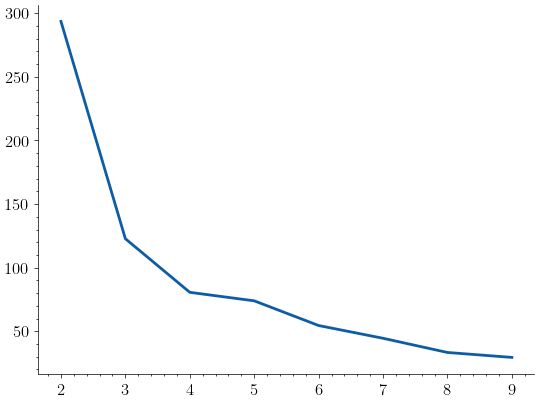

In [68]:
inertia =[] 
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X, kmeans.predict(X))
    print(f"{k} = {silhouette_avg}")

plt.plot(range(2,10),inertia)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto")

In [43]:
kmeans.fit(X)

KMeans(n_clusters=4, n_init='auto', random_state=0)

In [ ]:
kmeans_labels = kmeans.labels_
kmeans_labels[kmeans_labels == 2] = 3
kmeans_labels[kmeans_labels == 1] = 2
kmeans_labels[kmeans_labels == 3] = 1

dataframe['kmeans'] = kmeans_labels

    
dataframe.to_csv(f'{model}.csv', index=False)

In [46]:
kmeans.cluster_centers_

array([[ 0.24494244,  0.06557377],
       [ 2.46485222,  5.56521739],
       [ 1.54395426,  1.94117647],
       [ 3.09347765, 12.5       ]])

In [48]:
dataframe[dataframe['kmeans']==3]

,video,probs,entropy,crossings,labels,preds,curves,kmeans
73,S025_Rest_1_[0]_20s,0.385812,3.119165,13,0,False,"[0.6768382273614406, 0.6783451261619727, 0.681...",3
113,S043_Pain_1_[0]_20s,0.634959,3.067790,12,1,True,"[0.7231643550097943, 0.6928560088078181, 0.664...",3


In [37]:
stable = dataframe[dataframe['kmeans']==0]
irregular = dataframe[dataframe['kmeans']==1]
unstable = dataframe[dataframe['kmeans']==2]

for y in [stable, irregular, unstable]:
    print(f"{y['probs'].mean():.4f};{y['probs'].std():.4f}\n{y['entropy'].mean():.4f};{y['entropy'].std():.4f}\n{np.mean(y['crossings']):.4f};{y['crossings'].std():.4f}\n".replace('.',','))

0,6890;0,4352
0,3531;0,4575
0,1618;0,3710

0,5694;0,3084
1,7471;0,6391
2,5152;0,9056

0,5999;0,2023
2,5604;0,4552
6,7895;2,2992



In [38]:
time = np.linspace(0,20,571)

## Stable

In [39]:
stable.describe()

,probs,entropy,crossings,labels,kmeans
count,64.000000,64.000000,64.000000,64.000000,64.0
mean,0.568958,1.234496,0.187500,0.453125,0.0
std,0.376667,0.791962,0.393398,0.501733,0.0
min,0.006939,0.000000,0.000000,0.000000,0.0
25%,0.115842,0.578544,0.000000,0.000000,0.0
50%,0.798506,1.355253,0.000000,0.000000,0.0
75%,0.889337,1.859454,0.000000,1.000000,0.0
max,0.987044,2.644251,1.000000,1.000000,0.0


## By dataset

In [40]:
stable['labels'].value_counts()

labels
0    35
1    29
Name: count, dtype: int64

In [41]:
stable['preds'].value_counts()

preds
True     41
False    23
Name: count, dtype: int64

In [42]:
metrics = validation_metrics(stable['preds'], stable['probs'], stable['labels'])

for values in metrics.values():
    print(f"{values:.4f}".replace('.',","))

0,7188
0,7429
0,6341
0,8966
0,5714
0,7488


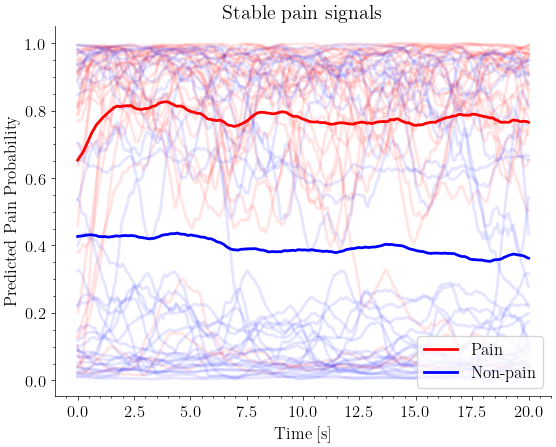

In [43]:
k_pain = np.array(stable[stable['labels']==1]['curves'])
k_nopain = np.array(stable[stable['labels']==0]['curves'])

mean_pain = np.mean(k_pain,axis=0)
mean_nopain = np.mean(k_nopain,axis=0)

for k in k_pain:
    plt.plot(time, k, 'r', alpha=0.1)

for k in k_nopain:
    plt.plot(time, k, 'b', alpha=0.1)

plt.plot(time, mean_pain, 'r', label='Pain')
plt.plot(time, mean_nopain, 'b', label='Non-pain')

plt.legend()
plt.title('Stable pain signals')
plt.xlabel('Time [s]')
plt.ylabel('Predicted Pain Probability')
plt.legend(loc="lower right")
plt.savefig(f"stable_signal_avg_{model}.svg", dpi=300, bbox_inches='tight')

In [44]:
for prediction, k_signal in zip(["PAIN", "NO-PAIN"],[k_pain, k_nopain]):

    delta_t_pain_k = []
    delta_t_nopain_k = []

    total_pain_events = []
    total_nopain_events = []

    for signal in k_signal:
        delta_t_pain, delta_t_nopain = get_delta_t(signal, theta_1)
        
        delta_t_pain_k.extend(delta_t_pain)
        delta_t_nopain_k.extend(delta_t_nopain)

        total_pain_events.append(len(delta_t_pain))
        total_nopain_events.append(len(delta_t_nopain))


    delta_t_pain_k = np.array(delta_t_pain_k)
    delta_t_nopain_k = np.array(delta_t_nopain_k)

    total_pain_events = np.array(total_pain_events)
    total_nopain_events = np.array(total_nopain_events)


    print(f"Label {prediction}: Painful Event duration {delta_t_pain_k.mean():.4f} ± {delta_t_pain_k.std():.2f}, # Occurances: {total_pain_events.mean():.4f} ± {total_pain_events.std():.4f}")
    print(f"Label {prediction}: Non-Painful Event duration {delta_t_nopain_k.mean():.4f} ± {delta_t_nopain_k.std():.2f} # Occurances: {total_nopain_events.mean():.4f} ± {total_nopain_events.std():.4f}")
    print()

Label PAIN: Painful Event duration 19.5992 ± 1.49, # Occurances: 0.8966 ± 0.3045
Label PAIN: Non-Painful Event duration 8.8026 ± 8.96 # Occurances: 0.2759 ± 0.4469

Label NO-PAIN: Painful Event duration 15.9357 ± 7.24, # Occurances: 0.5143 ± 0.4998
Label NO-PAIN: Non-Painful Event duration 17.2149 ± 6.22 # Occurances: 0.6857 ± 0.4642



## Irregular

In [45]:
irregular.describe()

,probs,entropy,crossings,labels,kmeans
count,34.000000,34.000000,34.000000,34.000000,34.0
mean,0.545467,2.641228,3.147059,0.382353,1.0
std,0.189527,0.461043,1.131702,0.493270,0.0
min,0.145618,1.354247,2.000000,0.000000,1.0
25%,0.439210,2.434004,2.000000,0.000000,1.0
50%,0.570899,2.771419,3.000000,0.000000,1.0
75%,0.661117,3.000408,4.000000,1.000000,1.0
max,0.871336,3.215781,5.000000,1.000000,1.0


In [46]:
irregular['labels'].value_counts()

labels
0    21
1    13
Name: count, dtype: int64

In [47]:
irregular['preds'].value_counts()

preds
True     28
False     6
Name: count, dtype: int64

In [48]:
metrics = (validation_metrics(irregular['preds'], irregular['probs'], irregular['labels']))

for values in metrics.values():
    print(f"{values:.4f}".replace('.',","))

0,3235
0,4390
0,3214
0,6923
0,0952
0,3297


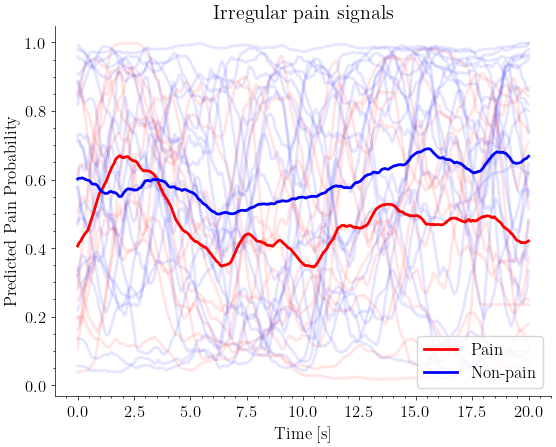

In [49]:
k_pain = np.array(irregular[irregular['labels']==1]['curves'])
k_nopain = np.array(irregular[irregular['labels']==0]['curves'])

mean_pain = np.mean(k_pain,axis=0)
mean_nopain = np.mean(k_nopain,axis=0)

for k in k_pain:
    plt.plot(time, k, 'r', alpha=0.1)

for k in k_nopain:
    plt.plot(time, k, 'b', alpha=0.1)

plt.plot(time, mean_pain, 'r', label='Pain')
plt.plot(time, mean_nopain, 'b', label='Non-pain')

plt.legend()
plt.title('Irregular pain signals')
plt.xlabel('Time [s]')
plt.ylabel('Predicted Pain Probability')
plt.legend(loc="lower right")
plt.savefig(f"irregular_signal_avg_{model}.svg", dpi=300, bbox_inches='tight')

In [50]:
for prediction, k_signal in zip(["PAIN", "NO-PAIN"],[k_pain, k_nopain]):

    delta_t_pain_k = []
    delta_t_nopain_k = []

    total_pain_events = []
    total_nopain_events = []

    for signal in k_signal:
        delta_t_pain, delta_t_nopain = get_delta_t(signal, theta_1)
        
        delta_t_pain_k.extend(delta_t_pain)
        delta_t_nopain_k.extend(delta_t_nopain)

        total_pain_events.append(len(delta_t_pain))
        total_nopain_events.append(len(delta_t_nopain))


    delta_t_pain_k = np.array(delta_t_pain_k)
    delta_t_nopain_k = np.array(delta_t_nopain_k)

    total_pain_events = np.array(total_pain_events)
    total_nopain_events = np.array(total_nopain_events)


    print(f"Label {prediction}: Painful Event duration {delta_t_pain_k.mean():.4f} ± {delta_t_pain_k.std():.2f}, # Occurances: {total_pain_events.mean():.4f} ± {total_pain_events.std():.4f}")
    print(f"Label {prediction}: Non-Painful Event duration {delta_t_nopain_k.mean():.4f} ± {delta_t_nopain_k.std():.2f} # Occurances: {total_nopain_events.mean():.4f} ± {total_nopain_events.std():.4f}")
    print()

Label PAIN: Painful Event duration 5.8208 ± 4.20, # Occurances: 2.1538 ± 0.6617
Label PAIN: Non-Painful Event duration 3.3454 ± 3.98 # Occurances: 2.2308 ± 0.5756

Label NO-PAIN: Painful Event duration 6.2140 ± 5.19, # Occurances: 2.3810 ± 0.7222
Label NO-PAIN: Non-Painful Event duration 3.2147 ± 3.19 # Occurances: 1.6190 ± 0.7854



## Unstable

In [51]:
unstable.describe()

,probs,entropy,crossings,labels,kmeans
count,22.000000,22.000000,22.000000,22.000000,22.0
mean,0.455657,2.617841,8.500000,0.318182,2.0
std,0.148875,0.389422,2.262531,0.476731,0.0
min,0.159660,1.644061,6.000000,0.000000,2.0
25%,0.333686,2.476282,7.000000,0.000000,2.0
50%,0.455873,2.659971,8.000000,0.000000,2.0
75%,0.574625,2.858140,9.750000,1.000000,2.0
max,0.714735,3.246362,14.000000,1.000000,2.0


In [52]:
unstable['labels'].value_counts()

labels
0    15
1     7
Name: count, dtype: int64

In [53]:
unstable['preds'].value_counts()

preds
True     16
False     6
Name: count, dtype: int64

In [54]:
metrics = (validation_metrics(unstable['preds'], unstable['probs'], unstable['labels']))

for values in metrics.values():
    print(f"{values:.4f}".replace('.',","))

0,5000
0,5217
0,3750
0,8571
0,3333
0,6095


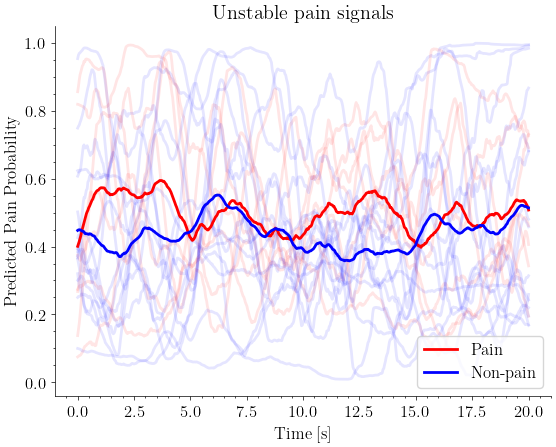

In [55]:
k_pain = np.array(unstable[unstable['labels']==1]['curves'])
k_nopain = np.array(unstable[unstable['labels']==0]['curves'])

mean_pain = np.mean(k_pain,axis=0)
mean_nopain = np.mean(k_nopain,axis=0)

for k in k_pain:
    plt.plot(time, k, 'r', alpha=0.1)

for k in k_nopain:
    plt.plot(time, k, 'b', alpha=0.1)

plt.plot(time, mean_pain, 'r', label='Pain')
plt.plot(time, mean_nopain, 'b', label='Non-pain')

plt.legend()
plt.title('Unstable pain signals')
plt.xlabel('Time [s]')
plt.ylabel('Predicted Pain Probability')
plt.legend(loc="lower right")
plt.savefig(f"unstable_signal_avg_{model}.svg", dpi=300, bbox_inches='tight')

In [56]:
for prediction, k_signal in zip(["PAIN", "NO-PAIN"],[k_pain, k_nopain]):

    delta_t_pain_k = []
    delta_t_nopain_k = []

    total_pain_events = []
    total_nopain_events = []

    for signal in k_signal:
        delta_t_pain, delta_t_nopain = get_delta_t(signal, theta_1)
        
        delta_t_pain_k.extend(delta_t_pain)
        delta_t_nopain_k.extend(delta_t_nopain)

        total_pain_events.append(len(delta_t_pain))
        total_nopain_events.append(len(delta_t_nopain))


    delta_t_pain_k = np.array(delta_t_pain_k)
    delta_t_nopain_k = np.array(delta_t_nopain_k)

    total_pain_events = np.array(total_pain_events)
    total_nopain_events = np.array(total_nopain_events)


    print(f"Label {prediction}: Painful Event duration {delta_t_pain_k.mean():.4f} ± {delta_t_pain_k.std():.2f}, # Occurances: {total_pain_events.mean():.4f} ± {total_pain_events.std():.4f}")
    print(f"Label {prediction}: Non-Painful Event duration {delta_t_nopain_k.mean():.4f} ± {delta_t_nopain_k.std():.2f} # Occurances: {total_nopain_events.mean():.4f} ± {total_nopain_events.std():.4f}")
    print()

Label PAIN: Painful Event duration 2.4459 ± 2.62, # Occurances: 5.8571 ± 1.2454
Label PAIN: Non-Painful Event duration 1.4185 ± 1.83 # Occurances: 4.0000 ± 1.6903

Label NO-PAIN: Painful Event duration 2.3572 ± 2.98, # Occurances: 4.8000 ± 0.6532
Label NO-PAIN: Non-Painful Event duration 1.9159 ± 2.71 # Occurances: 4.5333 ± 1.9276



In [57]:
for videoname, kmeans_label in zip(dataframe['video'], dataframe['kmeans']):
    for filename in os.listdir('C:\\Users\\leonardo\\Desktop\\icopevid_results\\NCNN\\'):
        if videoname in filename:
            os.rename(os.path.join('C:\\Users\\leonardo\\Desktop\\icopevid_results\\NCNN\\',filename),os.path.join(f'C:\\Users\\leonardo\\Desktop\\icopevid_results\\NCNN\\{kmeans_label}',filename))
            break

FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: 'C:\\Users\\leonardo\\Desktop\\icopevid_results\\NCNN\\'

In [58]:
import seaborn as sns

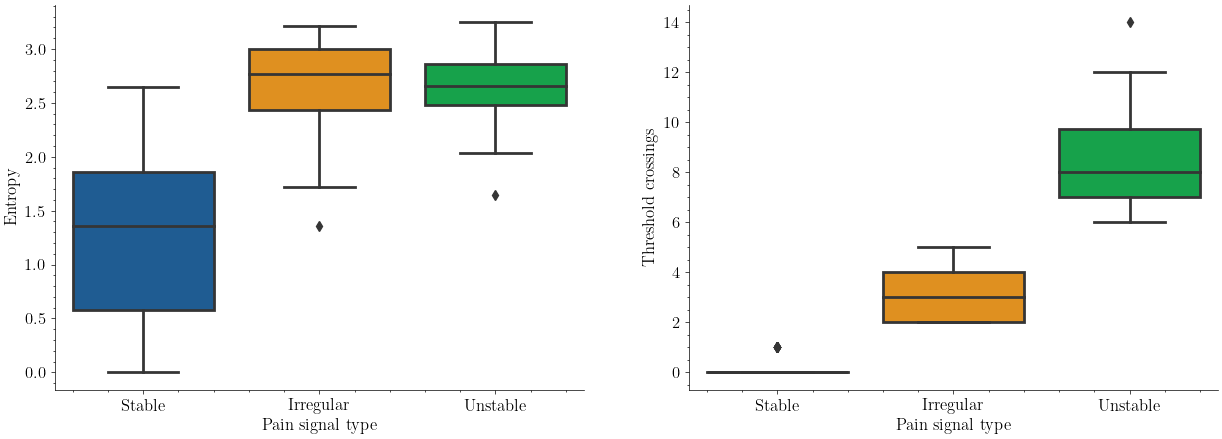

In [59]:
plt.figure(figsize=(15,5))

plt.subplot(121)

sns.boxplot(dataframe, y='entropy', x='kmeans')
plt.xticks([0,1,2],['Stable', "Irregular", "Unstable"])
plt.xlabel('Pain signal type')
plt.ylabel('Entropy')

plt.subplot(122)

sns.boxplot(dataframe, y='crossings', x='kmeans')
plt.xticks([0,1,2],['Stable', "Irregular", "Unstable"])
plt.xlabel('Pain signal type')
plt.ylabel('Threshold crossings')

plt.savefig(f"entropy_k_{model}.svg", dpi=300, bbox_inches='tight')


In [60]:
kmeans.cluster_centers_

array([[1.23449641, 0.1875    ],
       [2.61784053, 8.5       ],
       [2.64122819, 3.14705882]])

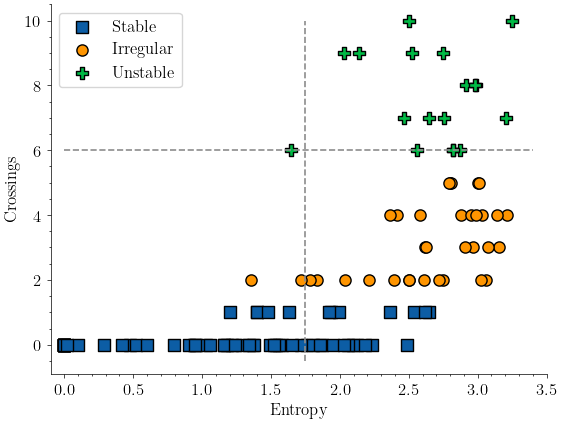

In [61]:
plt.scatter(stable['entropy'], stable['crossings'], marker='s', edgecolors='k', s=65, label='Stable')
plt.scatter(irregular['entropy'], irregular['crossings'], marker='o', edgecolors='k', s=65, label='Irregular')
plt.scatter(unstable['entropy'], unstable['crossings'], marker='P', edgecolors='k', s=65, label='Unstable')

plt.xlim([-0.1,3.5])
plt.ylim([-0.9,10.5])
plt.xlabel('Entropy')
plt.ylabel('Crossings')

#x1 = stable['entropy'].mean()+2*stable['entropy'].std()
#x2 = irregular['entropy'].mean()-2*irregular['entropy'].std()
#x = np.abs(x1-x2)/2

#y1 = irregular['crossings'].mean()+2*irregular['crossings'].std()
#y2 = unstable['crossings'].mean()-2*unstable['crossings'].std()
#y = np.abs(y1-y2)/2

vline = 1.25 if "VGG" in model else 1.75
hline = irregular['crossings'].max()+1

plt.vlines(vline , ymax=10, ymin=-0.5, color='#8c8c8c', linestyles='--', linewidth=1.2)
plt.hlines(hline, xmax=3.4, xmin=0, color='#8c8c8c', linestyles='--', linewidth=1.2)

plt.legend(loc='upper left')

model_name = "VGG-Face" if "VGG" in model else "N-CNN"
#plt.title(f'Pain Sign Types for {model_name}')

plt.savefig(f"plot_entropy_crossings_{model}.pdf", dpi=300, bbox_inches='tight')

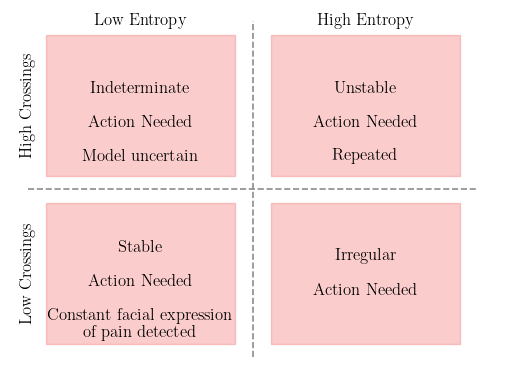

In [27]:
plt.axis('off')

plt.vlines(0.5 , ymax=1, ymin=0, color='#8c8c8c', linestyles='--', linewidth=1.2)
plt.hlines(0.5, xmax=1, xmin=0, color='#8c8c8c', linestyles='--', linewidth=1.2)

plt.text(0.75, 1, 'High Entropy', horizontalalignment='center', verticalalignment='center')
plt.text(0.25, 1, 'Low Entropy', horizontalalignment='center', verticalalignment='center')

plt.text(0, 0.75, 'High Crossings', horizontalalignment='center', verticalalignment='center', rotation=90)
plt.text(0, 0.25, 'Low Crossings', horizontalalignment='center', verticalalignment='center', rotation=90)

plt.text(0.75, 0.70, f"Unstable\n\nAction Needed\n\nRepeated", horizontalalignment='center', verticalalignment='center')
plt.text(0.75, 0.20, f"Irregular\n\nAction Needed\n\n ", horizontalalignment='center', verticalalignment='center')
plt.text(0.25, 0.70, f"Indeterminate\n\nAction Needed\n\nModel uncertain", horizontalalignment='center', verticalalignment='center')
plt.text(0.25, 0.20, f"Stable\n\nAction Needed\n\nConstant facial expression\n of pain detected ", horizontalalignment='center', verticalalignment='center')

plt.fill_between([0.04, 0.46], 0.04, 0.46, color='#f25757', alpha=0.3)
plt.fill_between([0.04, 0.46], 0.54, 0.96 , color='#f25757', alpha=0.3)
plt.fill_between([0.54, 0.96], 0.04, 0.46 , color='#f25757', alpha=0.3)
plt.fill_between([0.54, 0.96], 0.54, 0.96 , color='#f25757', alpha=0.3)


#plt.title(f'For "Pain" predictions of {model_name}')

#plt.savefig(f"pain_quadrant_{model}.pdf", dpi=300, bbox_inches='tight')

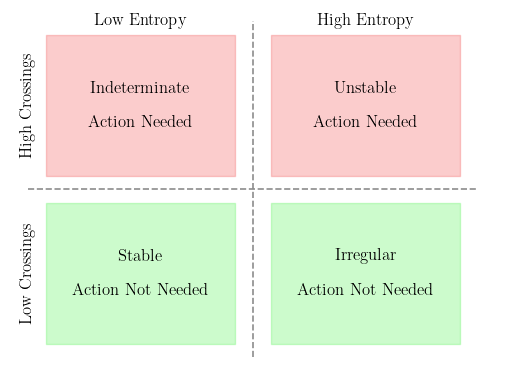

In [63]:
plt.axis('off')

plt.vlines(0.5 , ymax=1, ymin=0, color='#8c8c8c', linestyles='--', linewidth=1.2)
plt.hlines(0.5, xmax=1, xmin=0, color='#8c8c8c', linestyles='--', linewidth=1.2)

plt.text(0.75, 1, 'High Entropy', horizontalalignment='center', verticalalignment='center')
plt.text(0.25, 1, 'Low Entropy', horizontalalignment='center', verticalalignment='center')

plt.text(0, 0.75, 'High Crossings', horizontalalignment='center', verticalalignment='center', rotation=90)
plt.text(0, 0.25, 'Low Crossings', horizontalalignment='center', verticalalignment='center', rotation=90)

plt.text(0.75, 0.70, f"Unstable\n\nAction Needed\n\n", horizontalalignment='center', verticalalignment='center')
plt.text(0.75, 0.20, f"Irregular\n\nAction Not Needed\n\n", horizontalalignment='center', verticalalignment='center')
plt.text(0.25, 0.70, f"Indeterminate\n\nAction Needed\n\n", horizontalalignment='center', verticalalignment='center')
plt.text(0.25, 0.20, f"Stable\n\nAction Not Needed\n\n", horizontalalignment='center', verticalalignment='center')

plt.fill_between([0.04, 0.46], 0.04, 0.46, color='#57F257', alpha=0.3)
plt.fill_between([0.04, 0.46], 0.54, 0.96 , color='#f25757', alpha=0.3)
plt.fill_between([0.54, 0.96], 0.04, 0.46 , color='#57F257', alpha=0.3)
plt.fill_between([0.54, 0.96], 0.54, 0.96 , color='#f25757', alpha=0.3)

#plt.title(f'For "No-Pain" predictions of {model_name}')

plt.savefig(f"nopain_quadrant_{model}.pdf", dpi=300, bbox_inches='tight')

## Por formato do sinal

#### Sem normalização

In [64]:
X = dataframe['curves'].values

X = np.concatenate(X, axis=0)

X = X.reshape((120, 571))

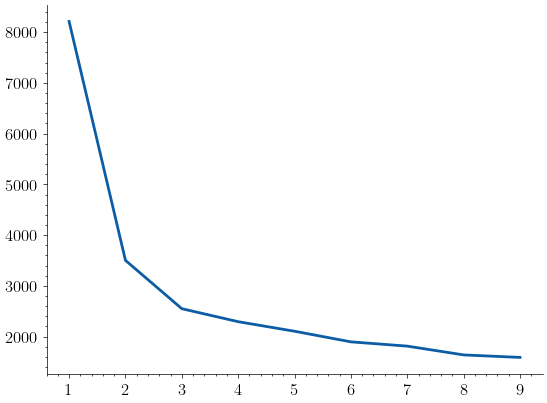

In [65]:
inertia =[] 
clusters = 10
for k in range(1, clusters):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,clusters),inertia)

In [148]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto")
kmeans.fit(X)
dataframe['kmeans_curves'] = kmeans.labels_

In [149]:
dataframe

,video,probs,entropy,crossings,labels,preds,curves,kmeans,kmeans_curves
0,S001_Pain_1_[0]_20s,0.339078,2.576976,3,1,False,"[0.00017042239463383642, 0.0001712686602938144...",1,1
1,S001_Rest_1_[0]_20s,0.000136,0.000000,0,0,False,"[2.6840963740445053e-05, 2.3289699811357423e-0...",0,0
2,S001_Rest_2_[0]_20s,0.074907,1.360848,1,0,False,"[0.6494866403440634, 0.6227291442453862, 0.594...",0,0
3,S001_Rest_2_[2]_20s,0.000574,0.000000,0,0,False,"[0.00041067133643082345, 0.0004184972041305930...",0,0
4,S002_Pain_1_[0]_20s,0.774134,1.472737,2,1,True,"[0.7638318638006846, 0.7736516098181406, 0.788...",1,1
...,...,...,...,...,...,...,...,...,...
115,S045_Pain_1_[0]_20s,0.310443,2.544921,4,1,False,"[0.0020413281531849255, 0.0018701815609044085,...",1,0
116,S046_Pain_1_[0]_20s,0.410341,3.138819,8,1,False,"[0.11033665299073618, 0.1393578725851209, 0.17...",2,0
117,S047_Pain_1_[0]_20s,0.996286,0.093791,0,1,True,"[0.7337941889573509, 0.7669088372262195, 0.800...",0,2
118,S048_Pain_1_[0]_20s,0.985968,0.346189,0,1,True,"[0.9977278749148051, 0.997851550579071, 0.9979...",0,2


In [150]:
stable = dataframe[dataframe['kmeans_curves']==0]
irregular = dataframe[dataframe['kmeans_curves']==1]
unstable = dataframe[dataframe['kmeans_curves']==2]

In [151]:
stable.describe()

,probs,entropy,crossings,labels,kmeans,kmeans_curves
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.0
mean,0.132702,1.072340,1.918919,0.162162,0.621622,0.0
std,0.154371,1.091813,2.861414,0.373684,0.758337,0.0
min,0.000015,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000574,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.042640,0.737145,1.000000,0.000000,0.000000,0.0
75%,0.260318,1.870729,2.000000,0.000000,1.000000,0.0
max,0.431182,3.138819,13.000000,1.000000,2.000000,0.0


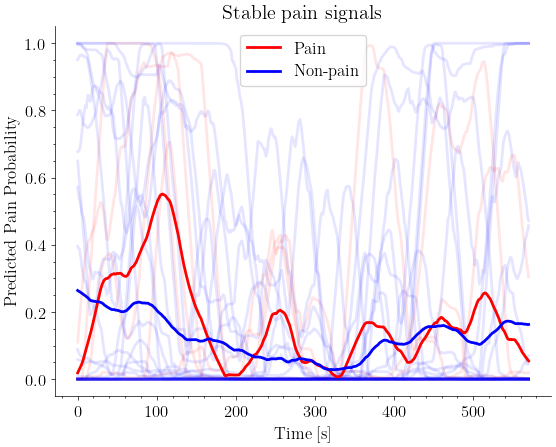

In [152]:
k_pain = np.array(stable[stable['labels']==1]['curves'])
k_nopain = np.array(stable[stable['labels']==0]['curves'])

mean_pain = np.mean(k_pain,axis=0)
mean_nopain = np.mean(k_nopain,axis=0)

for k in k_pain:
    plt.plot(k, 'r', alpha=0.1)

for k in k_nopain:
    plt.plot(k, 'b', alpha=0.1)

plt.plot(mean_pain, 'r', label='Pain')
plt.plot(mean_nopain, 'b', label='Non-pain')

plt.legend()
plt.title('Stable pain signals')
plt.xlabel('Time [s]')
plt.ylabel('Predicted Pain Probability')
plt.show()

In [153]:
irregular.describe()

,probs,entropy,crossings,labels,kmeans,kmeans_curves
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.0
mean,0.633389,2.395462,4.666667,0.277778,1.500000,1.0
std,0.140107,0.502315,2.543735,0.460889,0.618347,0.0
min,0.339078,1.245812,1.000000,0.000000,0.000000,1.0
25%,0.551207,2.178728,3.000000,0.000000,1.000000,1.0
50%,0.662413,2.409459,5.000000,0.000000,2.000000,1.0
75%,0.716833,2.772311,6.000000,0.750000,2.000000,1.0
max,0.804636,3.067790,12.000000,1.000000,2.000000,1.0


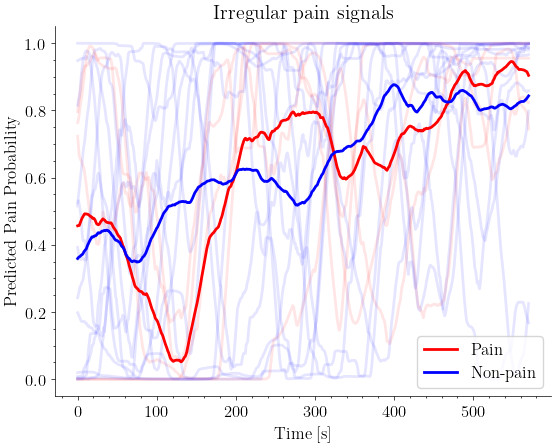

In [154]:
k_pain = np.array(irregular[irregular['labels']==1]['curves'])
k_nopain = np.array(irregular[irregular['labels']==0]['curves'])

mean_pain = np.mean(k_pain,axis=0)
mean_nopain = np.mean(k_nopain,axis=0)

for k in k_pain:
    plt.plot(k, 'r', alpha=0.1)

for k in k_nopain:
    plt.plot(k, 'b', alpha=0.1)

plt.plot(mean_pain, 'r', label='Pain')
plt.plot(mean_nopain, 'b', label='Non-pain')

plt.legend()
plt.title('Irregular pain signals')
plt.xlabel('Time [s]')
plt.ylabel('Predicted Pain Probability')
plt.show()

In [155]:
unstable.describe()

,probs,entropy,crossings,labels,kmeans,kmeans_curves
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.0
mean,0.934322,0.731071,1.046154,0.584615,0.323077,2.0
std,0.086916,0.758392,1.823722,0.496623,0.562019,0.0
min,0.578322,0.000000,0.000000,0.000000,0.000000,2.0
25%,0.905503,0.000000,0.000000,0.000000,0.000000,2.0
50%,0.974222,0.539143,0.000000,1.000000,0.000000,2.0
75%,0.997331,1.320981,2.000000,1.000000,1.000000,2.0
max,0.999978,2.634358,9.000000,1.000000,2.000000,2.0


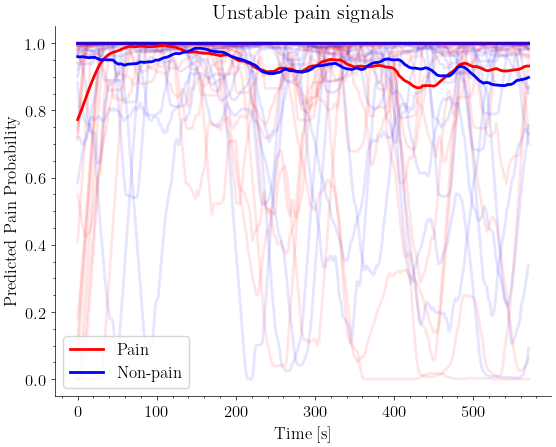

In [156]:
k_pain = np.array(unstable[unstable['labels']==1]['curves'])
k_nopain = np.array(unstable[unstable['labels']==0]['curves'])

mean_pain = np.mean(k_pain,axis=0)
mean_nopain = np.mean(k_nopain,axis=0)

for k in k_pain:
    plt.plot(k, 'r', alpha=0.1)

for k in k_nopain:
    plt.plot(k, 'b', alpha=0.1)

plt.plot(mean_pain, 'r', label='Pain')
plt.plot(mean_nopain, 'b', label='Non-pain')

plt.legend()
plt.title('Unstable pain signals')
plt.xlabel('Time [s]')
plt.ylabel('Predicted Pain Probability')
plt.show()

#### Com normalização

In [157]:
X = dataframe['curves'].values

X = np.concatenate(X, axis=0)

X = X.reshape((120, 571))

X_avg = X.mean(axis=1).reshape(120,1)

X = X - X_avg # Normalização pela pela média, evitando grupos por valores de probabilidade

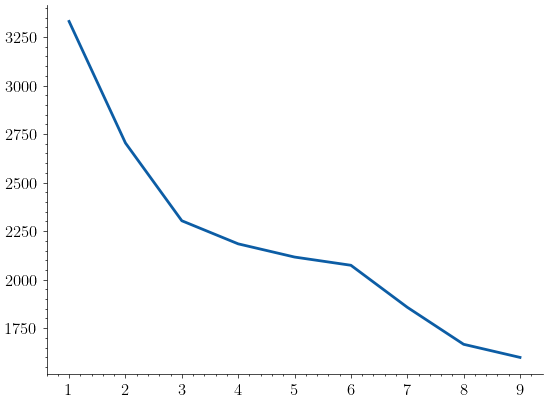

In [158]:
inertia =[] 
clusters = 10
for k in range(1, clusters):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,clusters),inertia)

In [159]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto")
kmeans.fit(X)
dataframe['kmeans_curves'] = kmeans.labels_

           probs    entropy  crossings     labels     kmeans  kmeans_curves
count  81.000000  81.000000  81.000000  81.000000  81.000000           81.0
mean    0.670053   0.615847   0.925926   0.407407   0.283951            0.0
std     0.426572   0.825920   2.078327   0.494413   0.596544            0.0
min     0.000015   0.000000   0.000000   0.000000   0.000000            0.0
25%     0.073143   0.000000   0.000000   0.000000   0.000000            0.0
50%     0.949980   0.346189   0.000000   0.000000   0.000000            0.0
75%     0.993689   0.890680   1.000000   1.000000   0.000000            0.0
max     0.999978   3.119165  13.000000   1.000000   2.000000            0.0


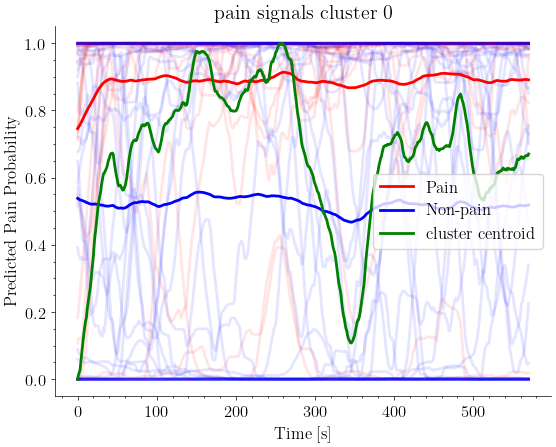

          probs   entropy  crossings  labels  kmeans  kmeans_curves
count  1.000000  1.000000        1.0     1.0     1.0            1.0
mean   0.403298  2.328953        3.0     0.0     1.0            1.0
std         NaN       NaN        NaN     NaN     NaN            NaN
min    0.403298  2.328953        3.0     0.0     1.0            1.0
25%    0.403298  2.328953        3.0     0.0     1.0            1.0
50%    0.403298  2.328953        3.0     0.0     1.0            1.0
75%    0.403298  2.328953        3.0     0.0     1.0            1.0
max    0.403298  2.328953        3.0     0.0     1.0            1.0


c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in longlong_scalars
  ret = ret / rcount


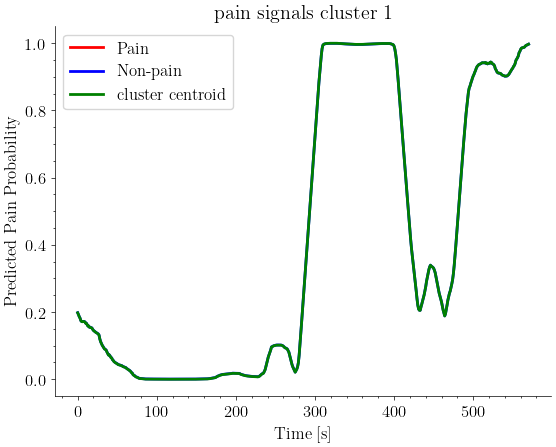

          probs   entropy  crossings    labels    kmeans  kmeans_curves
count  5.000000  5.000000   5.000000  5.000000  5.000000            5.0
mean   0.739561  2.378102   6.400000  0.400000  1.800000            2.0
std    0.093064  0.637564   3.435113  0.547723  0.447214            0.0
min    0.634959  1.630602   3.000000  0.000000  1.000000            2.0
25%    0.641116  1.999752   5.000000  0.000000  2.000000            2.0
50%    0.797175  2.175913   5.000000  0.000000  2.000000            2.0
75%    0.804636  3.016454   7.000000  1.000000  2.000000            2.0
max    0.819916  3.067790  12.000000  1.000000  2.000000            2.0


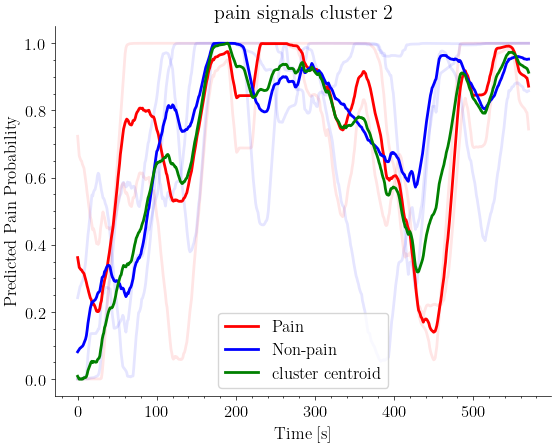

          probs   entropy  crossings    labels    kmeans  kmeans_curves
count  7.000000  7.000000   7.000000  7.000000  7.000000            7.0
mean   0.365392  2.071124   2.857143  0.285714  1.285714            3.0
std    0.205232  0.592479   1.951800  0.487950  0.487950            0.0
min    0.168164  1.237157   1.000000  0.000000  1.000000            3.0
25%    0.208606  1.783336   1.500000  0.000000  1.000000            3.0
50%    0.386365  1.996780   2.000000  0.000000  1.000000            3.0
75%    0.412933  2.328794   4.000000  0.500000  1.500000            3.0
max    0.760138  3.039671   6.000000  1.000000  2.000000            3.0


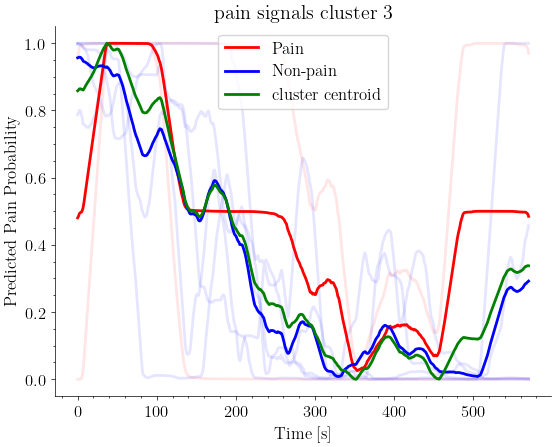

          probs   entropy  crossings  labels  kmeans  kmeans_curves
count  4.000000  4.000000   4.000000    4.00    4.00            4.0
mean   0.335770  1.997044   2.750000    0.25    0.75            4.0
std    0.080387  0.592687   1.258306    0.50    0.50            0.0
min    0.260318  1.223119   1.000000    0.00    0.00            4.0
25%    0.288138  1.708827   2.500000    0.00    0.75            4.0
50%    0.318245  2.094042   3.000000    0.00    1.00            4.0
75%    0.365877  2.382260   3.250000    0.25    1.00            4.0
max    0.446274  2.576976   4.000000    1.00    1.00            4.0


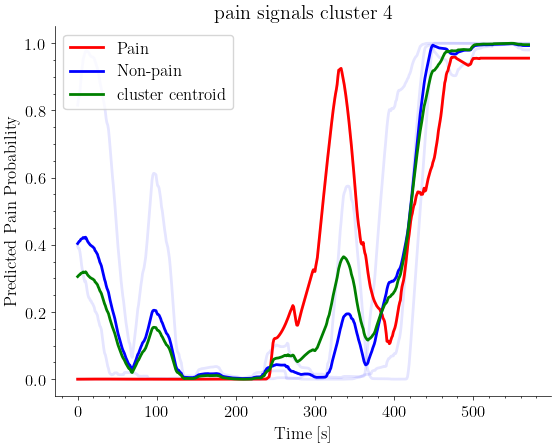

          probs   entropy  crossings  labels  kmeans  kmeans_curves
count  1.000000  1.000000        1.0     1.0     1.0            1.0
mean   0.526031  2.775189        6.0     0.0     2.0            5.0
std         NaN       NaN        NaN     NaN     NaN            NaN
min    0.526031  2.775189        6.0     0.0     2.0            5.0
25%    0.526031  2.775189        6.0     0.0     2.0            5.0
50%    0.526031  2.775189        6.0     0.0     2.0            5.0
75%    0.526031  2.775189        6.0     0.0     2.0            5.0
max    0.526031  2.775189        6.0     0.0     2.0            5.0


c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in longlong_scalars
  ret = ret / rcount


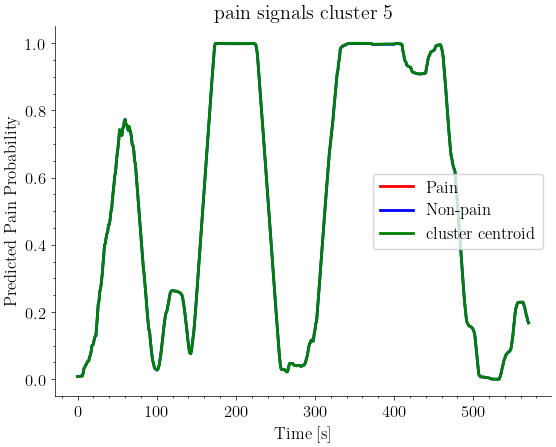

          probs   entropy  crossings  labels   kmeans  kmeans_curves
count  4.000000  4.000000   4.000000    4.00  4.00000            4.0
mean   0.747436  1.572840   2.000000    0.75  0.50000            6.0
std    0.134767  0.459422   1.154701    0.50  0.57735            0.0
min    0.578322  0.997315   1.000000    0.00  0.00000            6.0
25%    0.707823  1.306497   1.000000    0.75  0.00000            6.0
50%    0.751600  1.658594   2.000000    1.00  0.50000            6.0
75%    0.791213  1.924937   3.000000    1.00  1.00000            6.0
max    0.908220  1.976858   3.000000    1.00  1.00000            6.0


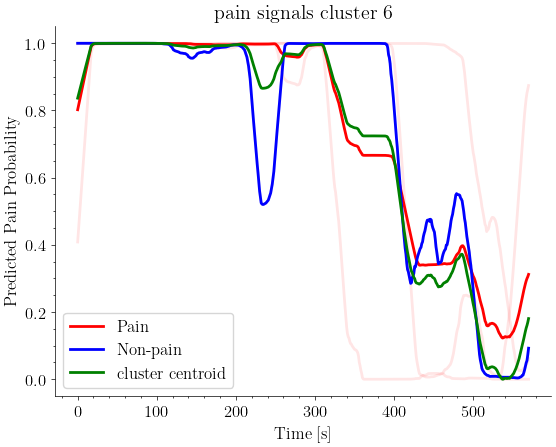

           probs    entropy  crossings     labels     kmeans  kmeans_curves
count  12.000000  12.000000  12.000000  12.000000  12.000000           12.0
mean    0.702754   2.143643   4.916667   0.500000   1.500000            7.0
std     0.221256   0.656437   2.353270   0.522233   0.522233            0.0
min     0.310443   0.982797   2.000000   0.000000   1.000000            7.0
25%     0.612031   1.827205   3.500000   0.000000   1.000000            7.0
50%     0.815057   2.142718   4.500000   0.500000   1.500000            7.0
75%     0.847849   2.655997   6.250000   1.000000   2.000000            7.0
max     0.905503   3.138819   9.000000   1.000000   2.000000            7.0


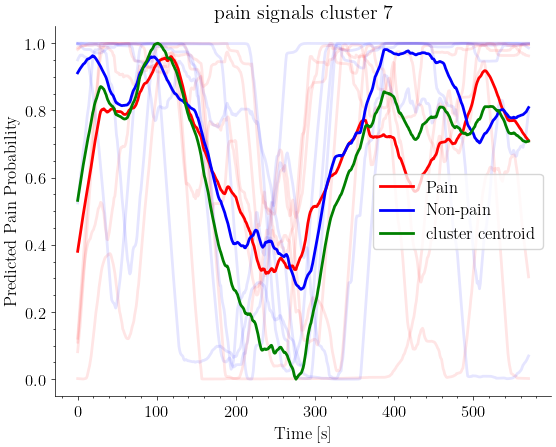

          probs   entropy  crossings   labels  kmeans  kmeans_curves
count  4.000000  4.000000   4.000000  4.00000    4.00            4.0
mean   0.639195  1.784511   1.750000  0.50000    0.75            8.0
std    0.121235  0.500023   0.957427  0.57735    0.50            0.0
min    0.482485  1.245812   1.000000  0.00000    0.00            8.0
25%    0.590674  1.416006   1.000000  0.00000    0.75            8.0
50%    0.650081  1.829955   1.500000  0.50000    1.00            8.0
75%    0.698602  2.198460   2.250000  1.00000    1.00            8.0
max    0.774134  2.232319   3.000000  1.00000    1.00            8.0


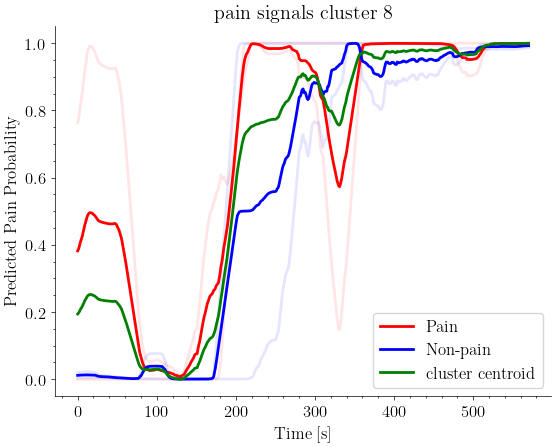

          probs   entropy  crossings  labels  kmeans  kmeans_curves
count  1.000000  1.000000        1.0     1.0     1.0            1.0
mean   0.260082  1.797096        2.0     0.0     1.0            9.0
std         NaN       NaN        NaN     NaN     NaN            NaN
min    0.260082  1.797096        2.0     0.0     1.0            9.0
25%    0.260082  1.797096        2.0     0.0     1.0            9.0
50%    0.260082  1.797096        2.0     0.0     1.0            9.0
75%    0.260082  1.797096        2.0     0.0     1.0            9.0
max    0.260082  1.797096        2.0     0.0     1.0            9.0


c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in longlong_scalars
  ret = ret / rcount


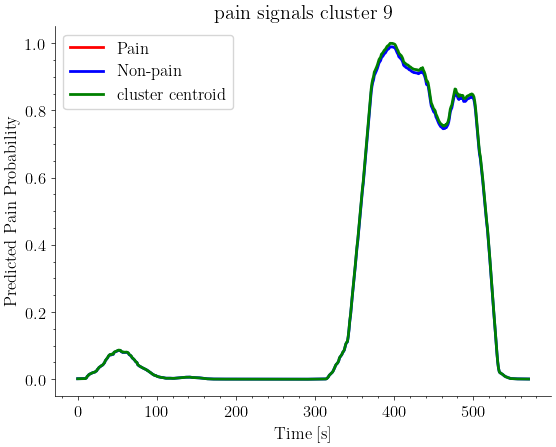

In [160]:
for i in range(10):
    signal_cluster = dataframe[dataframe['kmeans_curves']==i]

    print(signal_cluster.describe())
    
    k_pain = np.array(signal_cluster[signal_cluster['labels']==1]['curves'])
    k_nopain = np.array(signal_cluster[signal_cluster['labels']==0]['curves'])

    mean_pain = np.mean(k_pain,axis=0)
    mean_nopain = np.mean(k_nopain,axis=0)

    for k in k_pain:
        plt.plot(k, 'r', alpha=0.1)

    for k in k_nopain:
        plt.plot(k, 'b', alpha=0.1)

    plt.plot(mean_pain, 'r', label='Pain')
    plt.plot(mean_nopain, 'b', label='Non-pain')

    
    plt.plot((kmeans.cluster_centers_[i] - kmeans.cluster_centers_[i].min())/(kmeans.cluster_centers_[i].max() - kmeans.cluster_centers_[i].min()), 'g', label='cluster centroid')

    plt.legend()
    plt.title(f'pain signals cluster {i}')
    plt.xlabel('Time [s]')
    plt.ylabel('Predicted Pain Probability')
    plt.show()

for videoname, kmeans_label in zip(dataframe['video'], dataframe['kmeans']):
    for filename in os.listdir('C:\\Users\\leonardo\\Desktop\\icopevid results\\NCNN\\'):
        if videoname in filename:
            os.rename(os.path.join('C:\\Users\\leonardo\\Desktop\\icopevid results\\NCNN\\',filename),os.path.join(f'C:\\Users\\leonardo\\Desktop\\icopevid results\\NCNN\\{kmeans_label}',filename))
            break

In [161]:
import seaborn as sns

# Mean face

In [5]:
import cv2
import albumentations as A
from skimage.transform import AffineTransform, warp
from tqdm import tqdm

In [6]:
resize = A.Compose(
    [
        A.Resize(height=512, width=512, interpolation=cv2.INTER_CUBIC, p=1.0),
    ], 
    keypoint_params=A.KeypointParams(format="xy", remove_invisible=False))

In [7]:
path_mesh = 'Datasets\\landmarks'

faces = []
for i in os.listdir(path_mesh):
    with open(os.path.join(path_mesh,f'{i}'), 'rb') as f:
        face_mesh = np.array(pickle.load(f))

    faces.append(face_mesh)

faces_np = np.array(faces)
face_mesh_mean = faces_np.mean(axis=0)

landmarks_mean = np.array([face_mesh_mean[86], 
                           face_mesh_mean[52],
                           face_mesh_mean[61],
                           face_mesh_mean[88],
                           face_mesh_mean[38]])

In [8]:
save_path = "C:\\Users\\leonardo\\Desktop\\icopevid_results"

In [9]:
path_icopevid = 'Datasets\\Originais\\iCOPE\\iCOPEvid'
path_icopevid_frames = 'Datasets\\Originais\\iCOPE\\iCOPEvid\\all_frames'

model = 'VGGNB_test'

with open(os.path.join(path_icopevid_frames,f'results_{model}.pkl'), 'rb') as f:
    results_video = pickle.load(f)

In [10]:
column_video = []
column_idx = []
column_signal = []
column_correct = []

fold = '8'

for video in tqdm(results_video.keys()):
    idx = len(results_video[video][str(fold)])

    column_video.extend([video] * idx)
    column_idx.extend([f'{i:04d}' for i in range(idx)])
    column_signal.extend(results_video[video][str(fold)])

    pred = results_video[video][str(fold)] >= theta_1

    label = [True if video.split("_")[1] == "Pain" else False] * idx
    column_correct.extend(label==pred)

dataframe = pd.DataFrame({'video':column_video, 'correct': column_correct, 'idx': column_idx, 'signal': column_signal})

100%|██████████| 120/120 [00:00<00:00, 6666.00it/s]


In [11]:
dataframe['img_name'] = dataframe['video'] + "_" + dataframe['idx'] + ".jpg"

In [12]:
dataframe.tail()

,video,correct,idx,signal,img_name
71995,S049_Pain_1_[0]_20s,False,0595,0.036133,S049_Pain_1_[0]_20s_0595.jpg
71996,S049_Pain_1_[0]_20s,False,0596,0.039798,S049_Pain_1_[0]_20s_0596.jpg
71997,S049_Pain_1_[0]_20s,False,0597,0.047061,S049_Pain_1_[0]_20s_0597.jpg
71998,S049_Pain_1_[0]_20s,False,0598,0.042402,S049_Pain_1_[0]_20s_0598.jpg
71999,S049_Pain_1_[0]_20s,False,0599,0.039804,S049_Pain_1_[0]_20s_0599.jpg


In [13]:
import gc

In [14]:
# Generate confidence intervals only once
confs = np.arange(0.0, 1.01, 0.1).round(1)
transform_rigid = AffineTransform()

for correct in [True, False]:
    stacked_imgs = []

    # Group data once by confidence interval
    groups = {c: dataframe[(dataframe['signal'] >= confs[c]) & (dataframe['signal'] < confs[c+1]) & (dataframe['correct'] == correct)]
            for c in range(len(confs) - 1)}

    for conf, result in groups.items():
        if len(result) == 0:
            continue  # Skip empty groups

        warped_imgs = []

        # Load and process images in batches
        for _, sample in tqdm(result.iterrows(), total=len(result)):
            # Check for .jpg files only once
            if not sample['img_name'].endswith('.jpg'):
                continue

            full_frames_path = os.path.join(path_icopevid_frames, sample['video'])
            img_path = os.path.join(full_frames_path, sample['img_name'])

            # Load image and landmark file only if both exist
            if os.path.exists(img_path) and os.path.exists(os.path.join(full_frames_path, 'landmarks', sample['img_name'].replace('.jpg', '.pkl'))):
                img = cv2.imread(img_path)

                # Load face landmarks
                with open(os.path.join(full_frames_path, 'landmarks', sample['img_name'].replace('.jpg', '.pkl')), 'rb') as f:
                    face_mesh = pickle.load(f)

                # Resize image and landmarks
                resized = resize(image=img, keypoints=face_mesh)
                img = resized['image']
                face_mesh = resized['keypoints']

                # Select landmarks
                landmarks = np.array([
                    face_mesh[86],
                    face_mesh[52],
                    face_mesh[61],
                    face_mesh[88],
                    face_mesh[38]
                ])

                # Align image based on landmarks
                transform_rigid.estimate(src=landmarks_mean, dst=landmarks)
                result_img = warp(img, transform_rigid) * 255
                warped_imgs.append(result_img.astype(np.uint8))

        # Calculate mean of warped images if there are any
        if warped_imgs:
            print(len(warped_imgs))
            mean_img = np.mean(np.array(warped_imgs), axis=0) / 255
            stacked_imgs.append(mean_img)

    # Combine all mean images horizontally and save once
    if stacked_imgs:
        test_img = np.hstack(stacked_imgs) * 255
        cv2.imwrite(os.path.join(save_path, model + f"_stack_{correct}.jpg"), test_img.astype(np.uint8))

    gc.collect()  # Garbage collection only at the end


100%|██████████| 14588/14588 [08:24<00:00, 28.89it/s]


14588


100%|██████████| 2150/2150 [01:03<00:00, 33.65it/s]


2150


100%|██████████| 1412/1412 [00:41<00:00, 34.10it/s]


1412


100%|██████████| 1060/1060 [00:31<00:00, 33.88it/s]


1060


100%|██████████| 629/629 [00:18<00:00, 33.97it/s]


629


100%|██████████| 855/855 [00:25<00:00, 33.63it/s]


855


100%|██████████| 1019/1019 [00:30<00:00, 33.86it/s]


1019


100%|██████████| 1448/1448 [00:42<00:00, 33.91it/s]


1448


100%|██████████| 2702/2702 [01:20<00:00, 33.70it/s]


2702


100%|██████████| 17231/17231 [08:40<00:00, 33.13it/s]


17231


100%|██████████| 2750/2750 [01:21<00:00, 33.82it/s]


2750


100%|██████████| 948/948 [00:27<00:00, 33.90it/s]


948


100%|██████████| 706/706 [00:20<00:00, 33.98it/s]


706


100%|██████████| 1095/1095 [00:32<00:00, 33.59it/s]


1095


100%|██████████| 1537/1537 [00:45<00:00, 33.59it/s]


1537


100%|██████████| 1664/1664 [00:49<00:00, 33.40it/s]


1664


100%|██████████| 1391/1391 [00:41<00:00, 33.51it/s]


1391


100%|██████████| 1398/1398 [00:42<00:00, 33.14it/s]


1398


100%|██████████| 2312/2312 [01:10<00:00, 32.85it/s]


2312


100%|██████████| 14502/14502 [07:26<00:00, 32.45it/s]


14502


# Correlação entre sinais

In [2]:
from scipy.stats import pearsonr

In [3]:
model_NCNN = 'NCNN_test'
model_VGGNB = 'VGGNB_test'
model_ViTNB = 'ViTNB_test'

fold_NCNN = '9'
fold_VGGNB = '7'
fold_ViTNB = '8'

In [4]:
path_icopevid = 'Datasets\\Originais\\iCOPE\\iCOPEvid'
path_icopevid_frames = 'Datasets\\Originais\\iCOPE\\iCOPEvid\\all_frames'

with open(os.path.join(path_icopevid_frames,f'results_{model_NCNN}.pkl'), 'rb') as f:
    results_NCNN = pickle.load(f)

with open(os.path.join(path_icopevid_frames,f'results_{model_VGGNB}.pkl'), 'rb') as f:
    results_VGGNB = pickle.load(f)

with open(os.path.join(path_icopevid_frames,f'results_{model_ViTNB}.pkl'), 'rb') as f:
    results_ViTNB = pickle.load(f)

NCNN e VGGNB
Pearson: 0.5152 +- 0.3575
MSE: 0.0676 +- 0.0738

NCNN e ViTNB
Pearson: 0.5731 +- 0.3688
MSE: 0.0378 +- 0.0403

VGGNB e ViTNB
Pearson: 0.4945 +- 0.3255
MSE: 0.0776 +- 0.0850


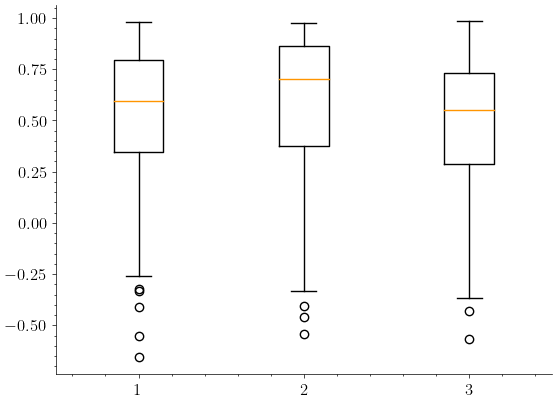

In [21]:
def calculate_pearson_correlation(df1, df2, column_name='curves'):
    # Extract the column from each dataframe
    data1 = df1[column_name]
    data2 = df2[column_name]
    
    # Calculate Pearson correlation
    corr, _ = pearsonr(data1, data2)
    return corr

all_pearson = []
pearson = []
mse = []

for video in results_NCNN.keys():

    interpoleted_curve_NCNN = interp_curve(results_NCNN[video][fold_NCNN])
    filtered_curve_NCNN = moving_average(interpoleted_curve_NCNN, 30)

    interpoleted_curve_VGGNB = interp_curve(results_VGGNB[video][fold_VGGNB])
    filtered_curve_VGGNB = moving_average(interpoleted_curve_VGGNB, 30)

    pearson.append(pearsonr(filtered_curve_NCNN, filtered_curve_VGGNB)[0])
    mse.append(((filtered_curve_NCNN - filtered_curve_VGGNB) ** 2).mean())

print('NCNN e VGGNB')
print(f'Pearson: {np.array(pearson).mean():.4f} +- {np.array(pearson).std():.4f}')
print(f'MSE: {np.array(mse).mean():.4f} +- {np.array(mse).std():.4f}')
print()
all_pearson.append(pearson)

pearson = []
mse = []

for video in results_NCNN.keys():

    interpoleted_curve_NCNN = interp_curve(results_NCNN[video][fold_NCNN])
    filtered_curve_NCNN = moving_average(interpoleted_curve_NCNN, 30)

    interpoleted_curve_ViTNB = interp_curve(results_ViTNB[video][fold_ViTNB])
    filtered_curve_ViTNB = moving_average(interpoleted_curve_ViTNB, 30)

    pearson.append(pearsonr(filtered_curve_NCNN, filtered_curve_ViTNB)[0])
    mse.append(((filtered_curve_NCNN - filtered_curve_ViTNB) ** 2).mean())

print('NCNN e ViTNB')
print(f'Pearson: {np.array(pearson).mean():.4f} +- {np.array(pearson).std():.4f}')
print(f'MSE: {np.array(mse).mean():.4f} +- {np.array(mse).std():.4f}')
print()
all_pearson.append(pearson)

pearson = []
mse = []

for video in results_NCNN.keys():

    interpoleted_curve_VGGNB = interp_curve(results_VGGNB[video][fold_VGGNB])
    filtered_curve_VGGNB = moving_average(interpoleted_curve_VGGNB, 30)

    interpoleted_curve_ViTNB = interp_curve(results_ViTNB[video][fold_ViTNB])
    filtered_curve_ViTNB = moving_average(interpoleted_curve_ViTNB, 30)

    pearson.append(pearsonr(filtered_curve_VGGNB, filtered_curve_ViTNB)[0])
    mse.append(((filtered_curve_VGGNB - filtered_curve_ViTNB) ** 2).mean())

print('VGGNB e ViTNB')
print(f'Pearson: {np.array(pearson).mean():.4f} +- {np.array(pearson).std():.4f}')
print(f'MSE: {np.array(mse).mean():.4f} +- {np.array(mse).std():.4f}')
all_pearson.append(pearson)

plt.boxplot(all_pearson)
plt.show()

In [42]:
NCNN_data = pd.read_csv('NCNN_test.csv')
VGGNB_data = pd.read_csv('VGGNB_test.csv')
ViTNB_data = pd.read_csv('ViTNB.csv')

In [43]:
NCNN_data.columns

Index(['video', 'probs', 'entropy', 'crossings', 'labels', 'preds', 'curves',
       'kmeans'],
      dtype='object')

In [44]:
NCNN_data.head()

,video,probs,entropy,crossings,labels,preds,curves,kmeans
0,S001_Pain_1_[0]_20s,0.361608,2.761368,5,1,False,[0.2223635 0.21414725 0.20678107 0.20041459 0...,2
1,S001_Rest_1_[0]_20s,0.046385,0.000000,0,0,False,[0.05303556 0.05120752 0.04912403 0.04686014 0...,0
2,S001_Rest_2_[0]_20s,0.154340,1.802336,0,0,False,[0.07445554 0.07513974 0.07583204 0.07608232 0...,0
3,S001_Rest_2_[2]_20s,0.234345,1.552873,0,0,False,[0.18140905 0.18424049 0.19072339 0.19551381 0...,0
4,S002_Pain_1_[0]_20s,0.717834,2.309820,2,1,True,[0.63836332 0.65634462 0.67221549 0.6882042 0...,1


In [45]:
VGGNB_data.head()

,video,probs,entropy,crossings,labels,preds,curves,kmeans
0,S001_Pain_1_[0]_20s,0.339078,2.576976,3,1,False,[1.70422395e-04 1.71268660e-04 1.73948409e-04 ...,1
1,S001_Rest_1_[0]_20s,0.000136,0.000000,0,0,False,[2.68409637e-05 2.32896998e-05 2.08642708e-05 ...,0
2,S001_Rest_2_[0]_20s,0.074907,1.360848,1,0,False,[6.49486640e-01 6.22729144e-01 5.94068001e-01 ...,0
3,S001_Rest_2_[2]_20s,0.000574,0.000000,0,0,False,[0.00041067 0.0004185 0.00042288 0.00043259 0...,0
4,S002_Pain_1_[0]_20s,0.774134,1.472737,2,1,True,[0.76383186 0.77365161 0.78832632 0.80864695 0...,1


In [46]:
ViTNB_data.head()

,video,probs,entropy,crossings,labels,preds,curves,kmeans
0,S001_Pain_1_[0]_20s,0.330584,2.748807,2,1,False,[0.19651393 0.19656484 0.19817471 0.20077855 0...,1
1,S001_Rest_1_[0]_20s,0.176620,1.218508,0,0,False,[0.32667144 0.32653304 0.32477351 0.32206164 0...,0
2,S001_Rest_2_[0]_20s,0.225067,1.395446,1,0,False,[0.53551963 0.53399519 0.52984102 0.52170672 0...,0
3,S001_Rest_2_[2]_20s,0.267603,1.644061,6,0,False,[0.25010025 0.25307812 0.25315403 0.25444058 0...,2
4,S002_Pain_1_[0]_20s,0.880795,1.758845,0,1,True,[0.82158933 0.82095025 0.82238347 0.82664719 0...,0


In [47]:
VGG_VIT = VGGNB_data['kmeans'] == ViTNB_data['kmeans'] 
VGG_NCNN = VGGNB_data['kmeans'] == NCNN_data['kmeans'] 
NCNN_VIT = NCNN_data['kmeans'] == ViTNB_data['kmeans'] 

In [55]:
test = (VGGNB_data['kmeans'] == ViTNB_data['kmeans']) & (NCNN_data['kmeans'] == ViTNB_data['kmeans'])

In [56]:
test.sum()/ len(test)

0.44166666666666665

In [57]:
ViTNB_data[test]

,video,probs,entropy,crossings,labels,preds,curves,kmeans
1,S001_Rest_1_[0]_20s,0.176620,1.218508,0,0,False,[0.32667144 0.32653304 0.32477351 0.32206164 0...,0
2,S001_Rest_2_[0]_20s,0.225067,1.395446,1,0,False,[0.53551963 0.53399519 0.52984102 0.52170672 0...,0
6,S002_Rest_2_[0]_20s,0.963580,0.000000,0,0,True,[0.93399961 0.93503433 0.93521762 0.93595644 0...,0
8,S003_Rest_1_[0]_20s,0.026926,0.000000,0,0,False,[0.04094064 0.04069662 0.04008246 0.03943683 0...,0
9,S003_Rest_2_[0]_20s,0.098486,0.938899,0,0,False,[0.08892392 0.08858546 0.08781602 0.08648714 0...,0
13,S004_Rest_2_[0]_20s,0.074367,0.908032,0,0,False,[0.07367666 0.0729911 0.07242868 0.07159405 0...,0
14,S005_Pain_1_[0]_20s,0.930538,1.183348,0,1,True,[0.70052326 0.69994711 0.69849849 0.69627246 0...,0
15,S005_Rest_1_[0]_20s,0.209787,1.161838,0,0,False,[0.22285843 0.22974762 0.2330097 0.23711984 0...,0
19,S006_Pain_1_[0]_20s,0.884897,1.536533,0,1,True,[0.63860216 0.64165917 0.64422556 0.64798254 0...,0
21,S006_Rest_2_[0]_20s,0.318341,2.643393,7,0,False,[0.39287308 0.39125371 0.38881474 0.38669636 0...,2


In [48]:
VGG_VIT.sum()/ len(VGG_VIT)

0.6583333333333333

In [49]:
VGG_NCNN.sum()/ len(VGG_NCNN)

0.575

In [50]:
NCNN_VIT.sum()/ len(NCNN_VIT)

0.6

In [51]:
def calculate_iou(array1, array2):
    # Convert arrays to sets
    set1 = set(array1)
    set2 = set(array2)

    # Calculate intersection and union
    intersection = set1.intersection(set2)
    union = set1.union(set2)

    # Calculate IoU
    iou = len(intersection) / len(union) if len(union) != 0 else 0
    return iou

In [52]:
array1 = NCNN_data[VGGNB_data['kmeans']==0]['video']
array2 = ViTNB_data[ViTNB_data['kmeans']==0]['video']


iou_score = calculate_iou(array1, array2)
print("IoU Score:", iou_score)

IoU Score: 0.6296296296296297


In [17]:
from scipy.stats import friedmanchisquare

In [18]:
x = [0.8361,0.8367,0.8621,0.7308,0.8039,0.8475,0.8095,0.8302,0.8889,0.8462]
y = [0.8197,0.9184,0.9138,0.8846,0.8039,0.8475,0.8730,0.9811,0.9722,0.8462]
z = [0.8525,0.7755,0.8793,0.6923,0.8431,0.8983,0.7619,0.8491,0.8889,0.9231]

In [19]:
friedmanchisquare(x,y,z)

FriedmanchisquareResult(statistic=3.166666666666676, pvalue=0.2052896575799083)